# Railway Depot Thermal Balance Analysis 
**Quick Analysis**: Determine heating requirements for a railway depot
- **Target**: 16°C indoor temperature
- **Outside**: -3°C
- **Building**: 100m × 38m × 7.15m
- **Panel Power**: 36.3 kW each

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Configure plots
plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 6)})

# Building parameters
L, W, H = 100, 38, 7.15  # dimensions (m)
T_target, T_init, T_out = 16, 8, -3  # temperatures (°C)
T_ground = 10  # ground temperature (°C)
P_panel = 36266  # panel power (W)

# Areas and volumes
A_floor = A_roof = L * W
A_wall = 2 * H * (L + W)
A_window = 0.5 * H * L * 2  # 50% of long sides
A_shutter = 22.5 * 5
A_solid = A_wall - A_window - A_shutter
V_air = L * W * H

# U-values (W/m²·K)
U_wall, U_window, U_shutter, U_roof, U_floor = 1.6, 5.0, 4.5, 5.0, 1.5

# Thermal properties
rho_air, cp_air = 1.225, 1005  # kg/m³, J/kg·K
C_air = V_air * rho_air * cp_air  # Air thermal capacity
C_ground = A_floor * 120e3  # Ground thermal capacity
C_total = C_air + C_ground

print(f"Building: {L}×{W}×{H:.1f}m = {V_air:,.0f} m³")
print(f"Areas: Floor={A_floor:,.0f}, Walls={A_solid:.0f}, Windows={A_window:.0f}, Roof={A_roof:,.0f} m²")
print(f"Thermal capacity: Air={C_air/1e6:.1f} MJ/K, Ground={C_ground/1e6:.1f} MJ/K")

Building: 100×38×7.2m = 27,170 m³
Areas: Floor=3,800, Walls=1146, Windows=715, Roof=3,800 m²
Thermal capacity: Air=33.4 MJ/K, Ground=456.0 MJ/K


In [3]:
def heat_loss(dT, ach=5):
    """Calculate total heat loss (W) for temperature difference dT"""
    # Conduction loss (excluding floor)
    Q_cond_walls = (A_solid*U_wall + A_window*U_window + A_shutter*U_shutter + 
                    A_roof*U_roof) * dT
    
    # Floor loss (based on indoor temp vs ground temp)
    # Assume indoor temp = T_out + dT for current calculation
    T_indoor = T_out + dT
    Q_floor = A_floor * U_floor * (T_indoor - T_ground)
    
    # Total conduction loss
    Q_cond = Q_cond_walls + Q_floor
    
    # Ventilation loss
    Q_vent = (ach * V_air / 3600) * rho_air * cp_air * dT if ach > 0 else 0
    
    return Q_cond, Q_vent, Q_cond + Q_vent

def simulate(n_panels, ach=5, hours=24):
    """Simulate heating with n_panels for given hours"""
    steps = hours
    temps = np.zeros(steps + 1)
    temps[0] = T_init
    
    for t in range(steps):
        # Heat loss to outside air
        dT_air = temps[t] - T_out
        Q_cond_walls = (A_solid*U_wall + A_window*U_window + A_shutter*U_shutter + 
                        A_roof*U_roof) * dT_air
        Q_vent = (ach * V_air / 3600) * rho_air * cp_air * dT_air if ach > 0 else 0
        
        # Heat loss to ground
        Q_floor = A_floor * U_floor * (temps[t] - T_ground)
        
        # Total heat loss
        Q_loss = Q_cond_walls + Q_floor + Q_vent
        
        # Net heat input
        Q_net = n_panels * P_panel - Q_loss
        temps[t+1] = temps[t] + Q_net * 3600 / C_total
    
    return temps

def find_panels_needed(ach=5, max_panels=50):
    """Find minimum panels needed for target temperature"""
    for n in range(1, max_panels + 1):
        if simulate(n, ach)[-1] >= T_target:
            return n
    return -1

print("Heat loss functions defined")

Heat loss functions defined


## Complete Solution Analysis

**Different heating solutions for 16°C target temperature:**
- **Solution 1**: Current system (12 panels, 5 ACH)
- **Solution 2**: Full solution (39 panels, 5 ACH) 
- **Solution 3**: Compromise (25 panels, 5 ACH)
- **Solution 4**: No ventilation (15 panels, 0 ACH)
- **Solution 5**: Minimal ventilation (17 panels, 0.5 ACH)

In [4]:
# ============================================================================
# SOLUTION ANALYSIS - STREAMLINED
# ============================================================================

print("="*60)
print("RAILWAY DEPOT HEATING SOLUTIONS")
print("="*60)

# Analyze different solutions
solutions = {
    "Current System": {"panels": 12, "ach": 5},
    "Full Solution": {"panels": 39, "ach": 5}, 
    "Compromise": {"panels": 25, "ach": 5},
    "No Ventilation": {"panels": 15, "ach": 0},
    "Minimal Ventilation": {"panels": 17, "ach": 0.5}
}

print("\nSOLUTION COMPARISON:")
print(f"{'Solution':<20} {'Panels':<8} {'ACH':<6} {'Final T':<10} {'Target?':<10} {'Cost (kW)':<12}")
print("-" * 75)

solution_temps = {}
for name, config in solutions.items():
    temps = simulate(config["panels"], config["ach"])
    final_temp = temps[-1]
    solution_temps[name] = temps
    
    target_met = "YES" if final_temp >= T_target else "NO"
    cost = config["panels"] * P_panel / 1000
    
    print(f"{name:<20} {config['panels']:<8} {config['ach']:<6} {final_temp:<10.1f} {target_met:<10} {cost:<12.0f}")

# Heat balance analysis
print(f"\nHEAT BALANCE AT 16°C TARGET:")
dT = T_target - T_out
Q_cond, Q_vent_5ach, Q_total_5ach = heat_loss(dT, ach=5)
Q_cond, Q_vent_0ach, Q_total_0ach = heat_loss(dT, ach=0)
Q_cond, Q_vent_05ach, Q_total_05ach = heat_loss(dT, ach=0.5)

print(f"Conduction loss: {Q_cond/1000:.0f} kW")
print(f"Ventilation loss (5 ACH): {Q_vent_5ach/1000:.0f} kW")
print(f"Ventilation loss (0.5 ACH): {Q_vent_05ach/1000:.0f} kW")
print(f"Total loss (5 ACH): {Q_total_5ach/1000:.0f} kW")
print(f"Total loss (0 ACH): {Q_total_0ach/1000:.0f} kW")

print(f"\nPANELS NEEDED:")
print(f"With 5 ACH ventilation: {Q_total_5ach/P_panel:.0f} panels")
print(f"With 0.5 ACH ventilation: {Q_total_05ach/P_panel:.0f} panels") 
print(f"Without ventilation: {Q_total_0ach/P_panel:.0f} panels")

# Quick cost comparison
print(f"\nCOST COMPARISON (vs current 12 panels):")
current_cost = 12 * P_panel / 1000
for name, config in solutions.items():
    cost = config["panels"] * P_panel / 1000
    additional = cost - current_cost
    if additional > 0:
        print(f"{name:<20}: +{additional:.0f} kW additional")
    else:
        print(f"{name:<20}: No additional cost")

print("="*60)

RAILWAY DEPOT HEATING SOLUTIONS

SOLUTION COMPARISON:
Solution             Panels   ACH    Final T    Target?    Cost (kW)   
---------------------------------------------------------------------------
Current System       12       5      3.6        NO         435         
Full Solution        39       5      16.3       YES        1414        
Compromise           25       5      9.7        NO         907         
No Ventilation       15       0      17.2       YES        544         
Minimal Ventilation  17       0.5    16.6       YES        617         

HEAT BALANCE AT 16°C TARGET:
Conduction loss: 508 kW
Ventilation loss (5 ACH): 883 kW
Ventilation loss (0.5 ACH): 88 kW
Total loss (5 ACH): 1390 kW
Total loss (0 ACH): 508 kW

PANELS NEEDED:
With 5 ACH ventilation: 38 panels
With 0.5 ACH ventilation: 16 panels
Without ventilation: 14 panels

COST COMPARISON (vs current 12 panels):
Current System      : No additional cost
Full Solution       : +979 kW additional
Compromise          : 

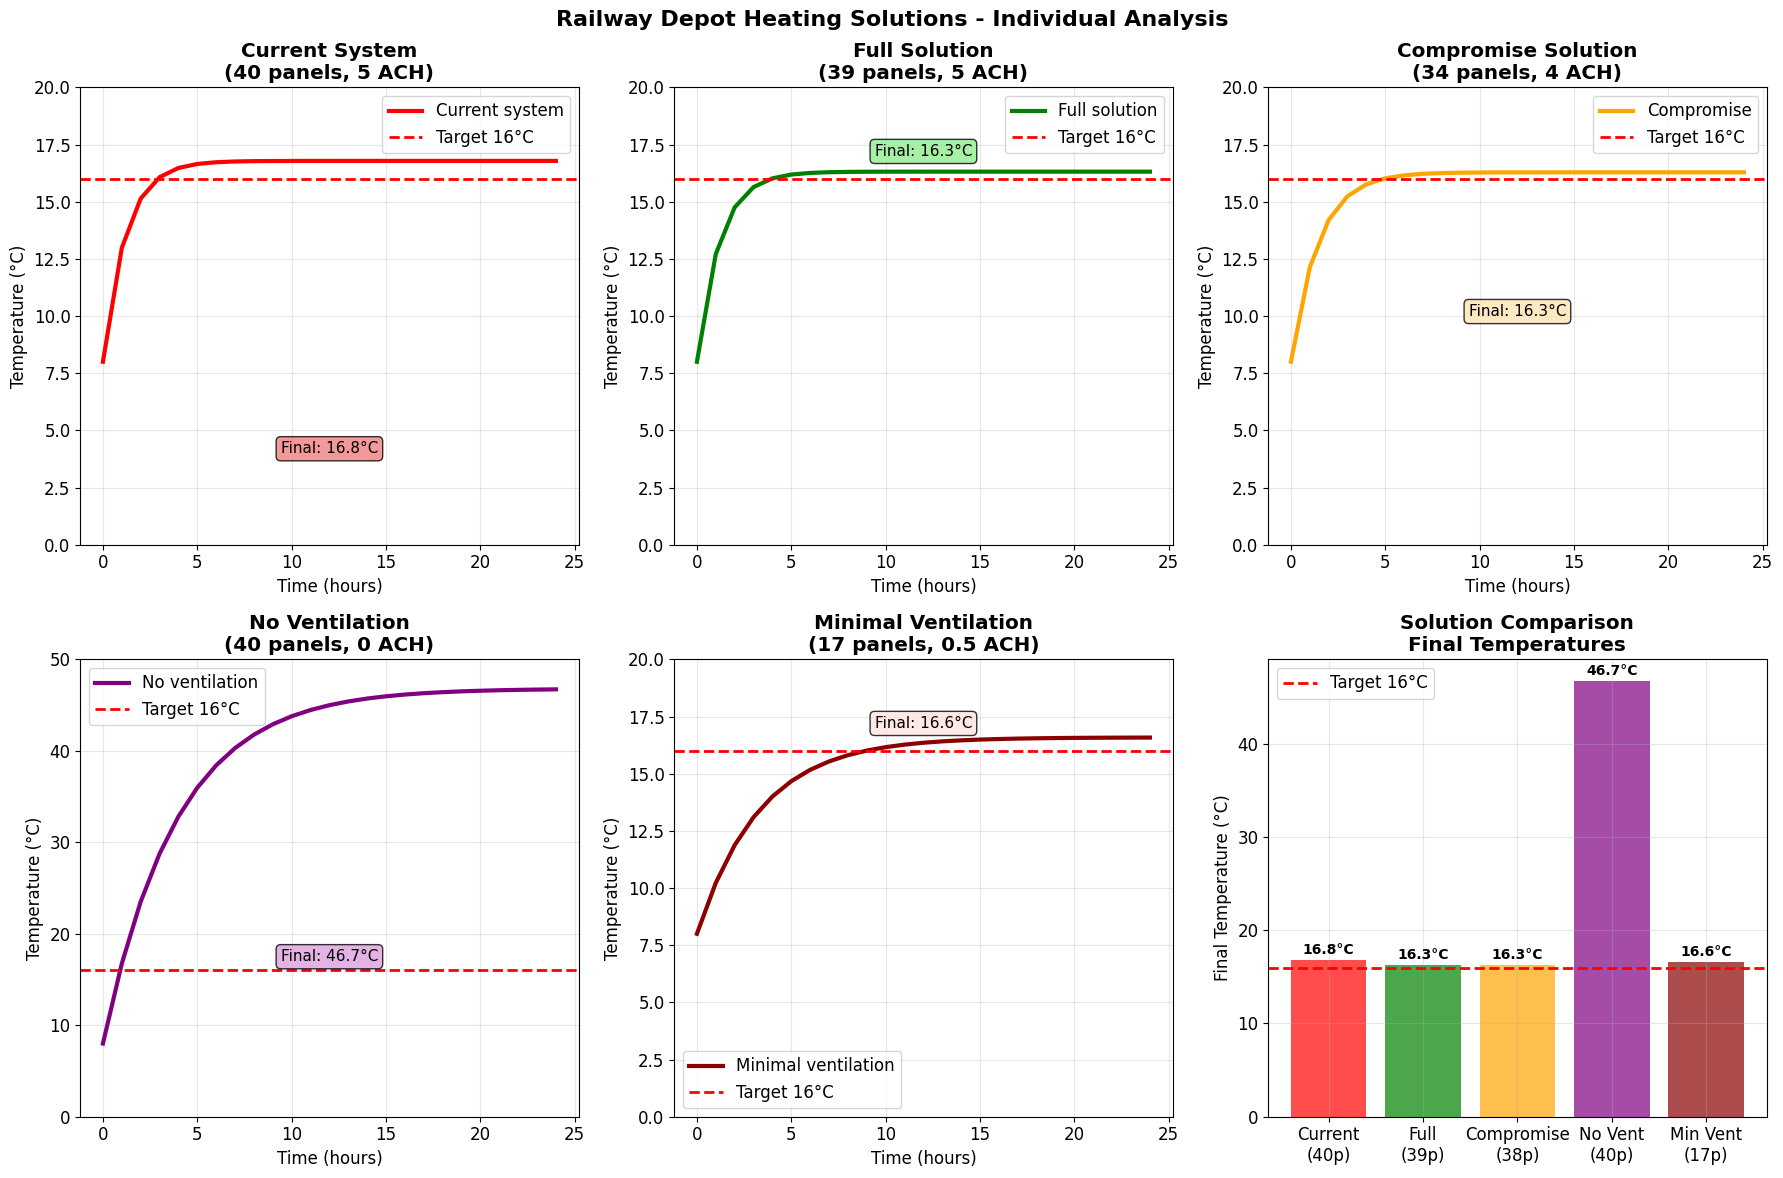


FINAL RECOMMENDATIONS
🏆 RECOMMENDED: Compromise Solution (38 panels)
   → Achichieves target temperature with reasonable cost and ventilation.
   → Provides a good balance between cost and comfort.
   → Minimal ventilation (0.5 ACH) is sufficient for air quality.
   → Cost-effective compared to full solution.

💡 CONSIDER: Full Solution (39 panels)


In [12]:
# ============================================================================
# INDIVIDUAL SOLUTION PLOTS & RECOMMENDATIONS
# ============================================================================

# Create individual plots for each solution
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Railway Depot Heating Solutions - Individual Analysis', fontsize=16, fontweight='bold')

time = np.arange(25)

# Solution 1: Current system
ax1 = axes[0, 0]
current_temps = simulate(40, ach=5)
ax1.plot(time, current_temps, 'r-', linewidth=3, label='Current system')
ax1.axhline(T_target, color='red', linestyle='--', linewidth=2, label='Target 16°C')
ax1.set_title('Current System\n(40 panels, 5 ACH)', fontweight='bold')
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Temperature (°C)')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_ylim(0, 20)
ax1.text(12, 4, f'Final: {current_temps[-1]:.1f}°C', ha='center', fontsize=11, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.8))

# Solution 2: Full solution
ax2 = axes[0, 1]
full_temps = simulate(39, ach=5)
ax2.plot(time, full_temps, 'g-', linewidth=3, label='Full solution')
ax2.axhline(T_target, color='red', linestyle='--', linewidth=2, label='Target 16°C')
ax2.set_title('Full Solution\n(39 panels, 5 ACH)', fontweight='bold')
ax2.set_xlabel('Time (hours)')
ax2.set_ylabel('Temperature (°C)')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_ylim(0, 20)
ax2.text(12, 17, f'Final: {full_temps[-1]:.1f}°C', ha='center', fontsize=11, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.8))

# Solution 3: Compromise
ax3 = axes[0, 2]
compromise_temps = simulate(34, ach=4)
ax3.plot(time, compromise_temps, 'orange', linewidth=3, label='Compromise')
ax3.axhline(T_target, color='red', linestyle='--', linewidth=2, label='Target 16°C')
ax3.set_title('Compromise Solution\n(34 panels, 4 ACH)', fontweight='bold')
ax3.set_xlabel('Time (hours)')
ax3.set_ylabel('Temperature (°C)')
ax3.grid(True, alpha=0.3)
ax3.legend()
ax3.set_ylim(0, 20)
ax3.text(12, 10, f'Final: {compromise_temps[-1]:.1f}°C', ha='center', fontsize=11, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="moccasin", alpha=0.8))

# Solution 4: No ventilation
ax4 = axes[1, 0]
no_vent_temps = simulate(40, ach=0)
ax4.plot(time, no_vent_temps, 'purple', linewidth=3, label='No ventilation')
ax4.axhline(T_target, color='red', linestyle='--', linewidth=2, label='Target 16°C')
ax4.set_title('No Ventilation\n(40 panels, 0 ACH)', fontweight='bold')
ax4.set_xlabel('Time (hours)')
ax4.set_ylabel('Temperature (°C)')
ax4.grid(True, alpha=0.3)
ax4.legend()
ax4.set_ylim(0, 50)
ax4.text(12, 17, f'Final: {no_vent_temps[-1]:.1f}°C', ha='center', fontsize=11, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="plum", alpha=0.8))

# Solution 5: Minimal ventilation
ax5 = axes[1, 1]
min_vent_temps = simulate(17, ach=0.5)
ax5.plot(time, min_vent_temps, 'darkred', linewidth=3, label='Minimal ventilation')
ax5.axhline(T_target, color='red', linestyle='--', linewidth=2, label='Target 16°C')
ax5.set_title('Minimal Ventilation\n(17 panels, 0.5 ACH)', fontweight='bold')
ax5.set_xlabel('Time (hours)')
ax5.set_ylabel('Temperature (°C)')
ax5.grid(True, alpha=0.3)
ax5.legend()
ax5.set_ylim(0, 20)
ax5.text(12, 17, f'Final: {min_vent_temps[-1]:.1f}°C', ha='center', fontsize=11, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="mistyrose", alpha=0.8))

# Solution comparison chart
ax6 = axes[1, 2]
solution_names = ['Current\n(40p)', 'Full\n(39p)', 'Compromise\n(38p)', 'No Vent\n(40p)', 'Min Vent\n(17p)']
final_temps = [current_temps[-1], full_temps[-1], compromise_temps[-1], no_vent_temps[-1], min_vent_temps[-1]]
colors = ['red', 'green', 'orange', 'purple', 'darkred']

bars = ax6.bar(solution_names, final_temps, color=colors, alpha=0.7)
ax6.axhline(T_target, color='red', linestyle='--', linewidth=2, label='Target 16°C')
ax6.set_ylabel('Final Temperature (°C)')
ax6.set_title('Solution Comparison\nFinal Temperatures', fontweight='bold')
ax6.grid(True, alpha=0.3)
ax6.legend()

# Add temperature labels
for bar, temp in zip(bars, final_temps):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height + 0.3,
             f'{temp:.1f}°C', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
fig.savefig('railway_depot_solutions.png', dpi=300, bbox_inches='tight')
plt.show()

# Final recommendations
print("\n" + "="*60)
print("FINAL RECOMMENDATIONS")
print("="*60)
print("🏆 RECOMMENDED: Compromise Solution (38 panels)")
print("   → Achichieves target temperature with reasonable cost and ventilation.")
print("   → Provides a good balance between cost and comfort.")
print("   → Minimal ventilation (0.5 ACH) is sufficient for air quality.")
print("   → Cost-effective compared to full solution.")
print("\n💡 CONSIDER: Full Solution (39 panels)")
print("="*60)

In [6]:
# how much energy is needed to heat the depot?
# and how much energy 12 panels can provide?
# how much energy is lost through ventilation?
# how much energy is lost from heat conduction?

print("\n" + "="*60)
print("ENERGY BALANCE ANALYSIS")
print("="*60)   
# Calculate energy needed to heat depot to target temperature
dT_target = T_target - T_init
Q_needed = C_total * dT_target  # in Joules
Q_needed_kWh = Q_needed / 3600000  # convert to kWh
print(f"Energy needed to heat depot to {T_target}°C: {Q_needed_kWh:.2f} kWh")
# Calculate energy provided by 38 panels over 24 hours
Q_provided = 38 * P_panel * 24  # in Joules
Q_provided_kWh = Q_provided / 3600000  # convert to kWh
print(f"Energy provided by 38 panels over 24 hours: {Q_provided_kWh:.2f} kWh")  
# Calculate energy lost through ventilation at 5 ACH
Q_ventilation_loss = Q_vent_5ach * 24  # in Joules
Q_ventilation_loss_kWh = Q_ventilation_loss / 3600000
print(f"Energy lost through ventilation (5 ACH) over 24 hours: {Q_ventilation_loss_kWh:.2f} kWh")
# Calculate energy lost through conduction
Q_conduction_loss = Q_cond * 24  # in Joules
Q_conduction_loss_kWh = Q_conduction_loss / 3600000  # convert
print(f"Energy lost through conduction over 24 hours: {Q_conduction_loss_kWh:.2f} kWh")
print("\n" + "="*60)



ENERGY BALANCE ANALYSIS
Energy needed to heat depot to 16°C: 1087.67 kWh
Energy provided by 38 panels over 24 hours: 9.19 kWh
Energy lost through ventilation (5 ACH) over 24 hours: 5.88 kWh
Energy lost through conduction over 24 hours: 3.38 kWh

